<a href="https://colab.research.google.com/github/HarinduR/FeatherFind/blob/Keyword-Bird-Finder/DSGP_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install scikit-multilearn
!pip install imbalanced-learn


In [35]:
!pip install tensorflow-addons

In [36]:
import numpy as np
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.base import clone

class MultiLabelSMOTE:
    def __init__(self, sampler=SMOTE(), classifier=LogisticRegression()):
        self.sampler = sampler
        self.classifier = classifier
        self.models = {}

    def fit_resample(self, X, y):
        # Apply SMOTE to each label independently
        self.models = {}
        for label_idx in range(y.shape[1]):
            sampler = clone(self.sampler)
            X_res, y_res = sampler.fit_resample(X, y[:, label_idx])
            model = clone(self.classifier).fit(X_res, y_res)
            self.models[label_idx] = model
        return X, y  # Returns original data but stores per-label models

    def predict(self, X):
        preds = np.zeros((X.shape[0], len(self.models)))
        for idx, model in self.models.items():
            preds[:, idx] = model.predict_proba(X)[:, 1]
        return preds

In [37]:
# First install required package

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline


# Load and prepare data
df = pd.read_csv("/content/bird_features_full_dataset.csv")
label_columns = ["Size", "Primary Color", "Secondary Color", "Habitat", "Region",
                "Diet", "Beak Size", "Beak Color", "Legs Size", "Legs Color",
                "Eyes Size", "Eyes Color"]

# Convert labels to binary matrix
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df[label_columns].apply(lambda x: [f"{k}={v}" for k,v in x.items() if v != "none"], axis=1))
X = df["Description"]

# Split data (preserve original splits)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

class SMOTEWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='minority'):
        self.sampler = SMOTE(sampling_strategy=sampling_strategy)

    def fit(self, X, y):
        # SMOTE requires y to be 1D, so we handle each label separately
        self.samplers_ = []
        for label_idx in range(y.shape[1]):
            sampler = clone(self.sampler)
            sampler.fit_resample(X, y[:, label_idx])
            self.samplers_.append(sampler)
        return self

    def transform(self, X):
        # Return original X since SMOTE is only applied during resampling
        return X

    def fit_resample(self, X, y):
        # Apply SMOTE to each label independently
        X_resampled, y_resampled = [], []
        for label_idx, sampler in enumerate(self.samplers_):
            X_res, y_res = sampler.fit_resample(X, y[:, label_idx])
            X_resampled.append(X_res)
            y_resampled.append(y_res)

        # Combine results
        X_combined = np.vstack(X_resampled)
        y_combined = np.vstack(y_resampled)
        return X_combined, y_combined

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500)),
    ('smote', SMOTEWrapper(sampling_strategy='minority')),
    ('clf', MultiOutputClassifier(LogisticRegression(class_weight='balanced')))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.50      0.20        16
           1       0.12      0.43      0.19        14
           2       0.09      0.50      0.15        12
           3       0.11      0.47      0.17        15
           4       0.11      0.56      0.18        16
           5       0.48      0.51      0.49        91
           6       0.05      0.44      0.10         9
           7       0.05      0.27      0.08        11
           8       0.17      0.39      0.23        18
           9       0.02      0.12      0.03         8
          10       0.31      0.36      0.33        25
          11       0.30      0.88      0.45        24
          12       0.56      0.85      0.68        78
          13       0.40      0.73      0.51        26
          14       0.42      0.76      0.54        29
          15       0.38      0.71      0.49        28
          16       0.33      0.74      0.46        19
          17       0.47    

In [47]:
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=500)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Verify shapes
print(f"Training data shape: {X_train_vec.shape}")  # Should be (num_samples, 500)
print(f"Test data shape: {X_test_vec.shape}")        # Should be (num_samples, 500)
print(f"y_train shape: {y_train.shape}")             # Should be (num_samples, num_labels)

# Calculate class weights
pos_weights = (len(y_train) - y_train.sum(axis=0)) / y_train.sum(axis=0)
class_weights = {i: weight for i, weight in enumerate(pos_weights)}

# Build a simple neural network
input_shape = X_train_vec.shape[1]
num_labels = y_train.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_labels, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_vec, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_vec, y_test),
    class_weight=class_weights
)

# Evaluate
y_pred = (model.predict(X_test_vec) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

Training data shape: (840, 129)
Test data shape: (210, 129)
y_train shape: (840, 97)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0095 - loss: 6.0660 - val_accuracy: 0.0048 - val_loss: 0.5900
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0017 - loss: 4.6940 - val_accuracy: 0.0000e+00 - val_loss: 0.3622
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 3.3886 - val_accuracy: 0.0000e+00 - val_loss: 0.3481
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 3.4134 - val_accuracy: 0.0000e+00 - val_loss: 0.3458
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 3.2701 - val_accuracy: 0.0000e+00 - val_loss: 0.3458
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 3.3575 - val_accuracy: 0.0000e+00 - val_loss: 0.3458
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 3.1874 - val_accuracy: 0.0000e+00 - val_loss: 0.3454
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


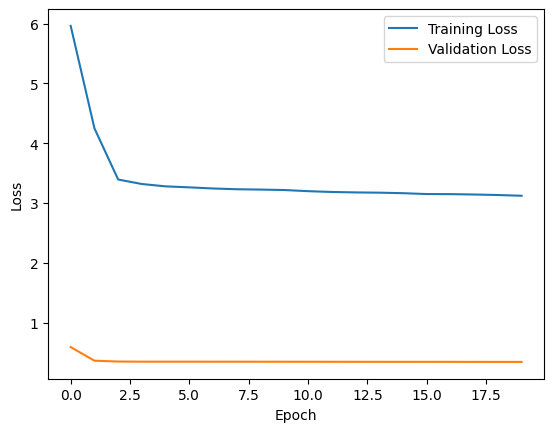

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()